# LINEAR SVC SPAM HAM

In [39]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile
import urllib.request

In [40]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
urllib.request.urlretrieve(url, "smsspamcollection.zip")

with zipfile.ZipFile("smsspamcollection.zip") as z:
    with z.open("SMSSpamCollection") as f:
        df = pd.read_csv(f, sep="\t", names=["label", "message"])

print(df.head())
print(df["label"].value_counts())

df["label"] = df["label"].map({"ham": 0, "spam": 1})
df["message_length"] = df["message"].apply(len)
print(df.head())

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df["message"])
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64
   label                                            message  message_length
0      0  Go until jurong point, crazy.. Available only ...             111
1      0                      Ok lar... Joking wif u oni...              29
2      1  Free entry in 2 a wkly comp to win FA Cup fina...             155
3      0  U dun say so early hor... U c already then say...              49
4      0  Nah I don't think he goes to usf, he lives aro...              61


In [45]:
svc_model = Pipeline([
    ("svc", LinearSVC(C=1.0, random_state=42))
])
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precisión: {precision * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Reporte de clasificación: \n{classification_report(y_test, y_pred, zero_division=0)}")

Accuracy: 98.21%
Precisión: 98.65%
F1-score: 95.92%
Recall: 93.57%
Reporte de clasificación: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



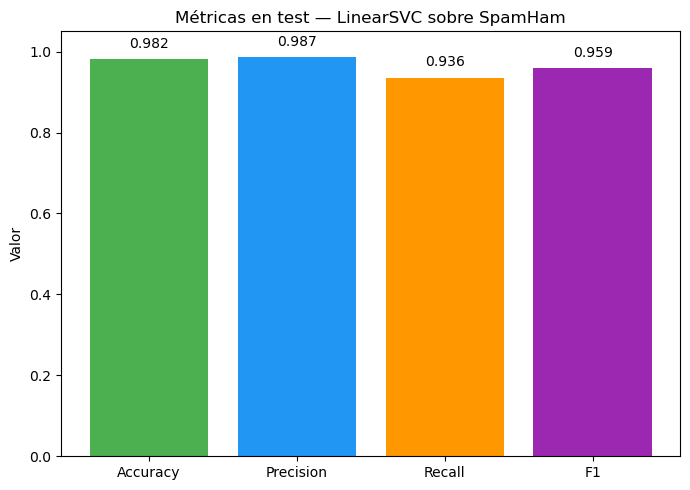

In [46]:
metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metric_vals  = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
bars = plt.bar(metric_names, metric_vals, color=["#4caf50", "#2196f3", "#ff9800", "#9c27b0"])
plt.ylim(0, 1.05)
plt.title("Métricas en test — LinearSVC sobre SpamHam")
plt.ylabel("Valor")
for rect, val in zip(bars, metric_vals):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height + 0.02, f"{val:.3f}",
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

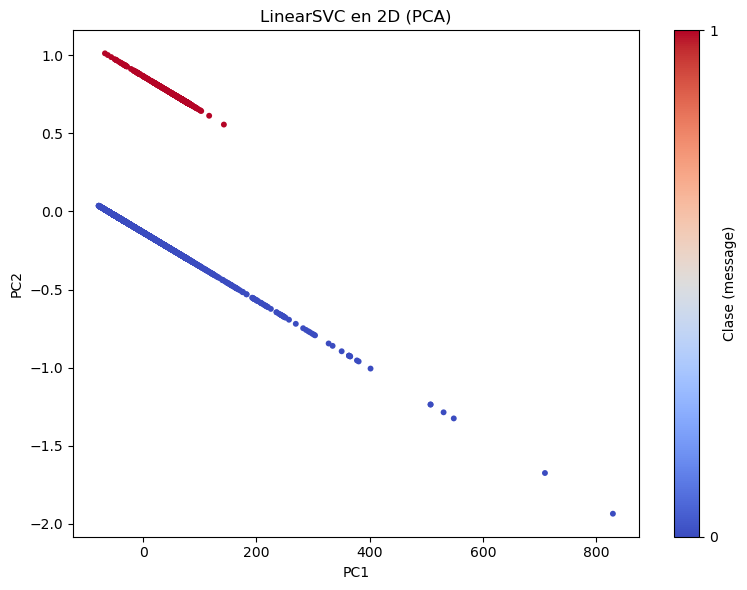

In [47]:
X_for_pca = df[["message_length", "label"]].values
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_for_pca)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", s=18, edgecolor="none")
plt.title("LinearSVC en 2D (PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2")
cbar = plt.colorbar(scatter, ticks=range(2))
cbar.set_label("Clase (message)")
plt.tight_layout()
plt.show()

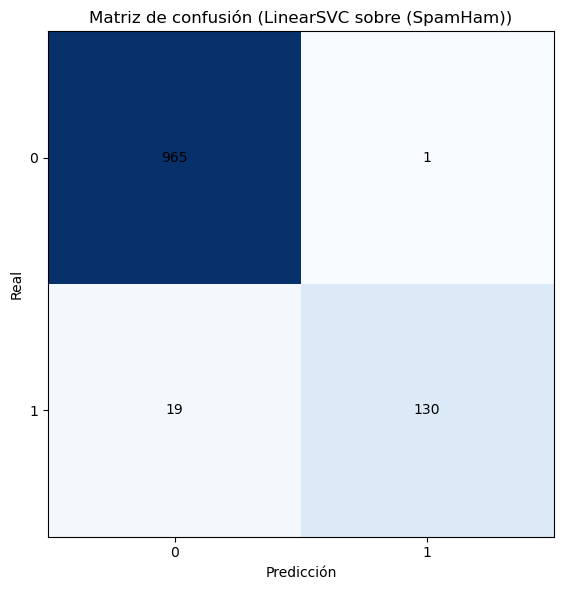

In [48]:
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Matriz de confusión (LinearSVC sobre (SpamHam))")
plt.xticks(ticks=range(2), labels=range(2))
plt.yticks(ticks=range(2), labels=range(2))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

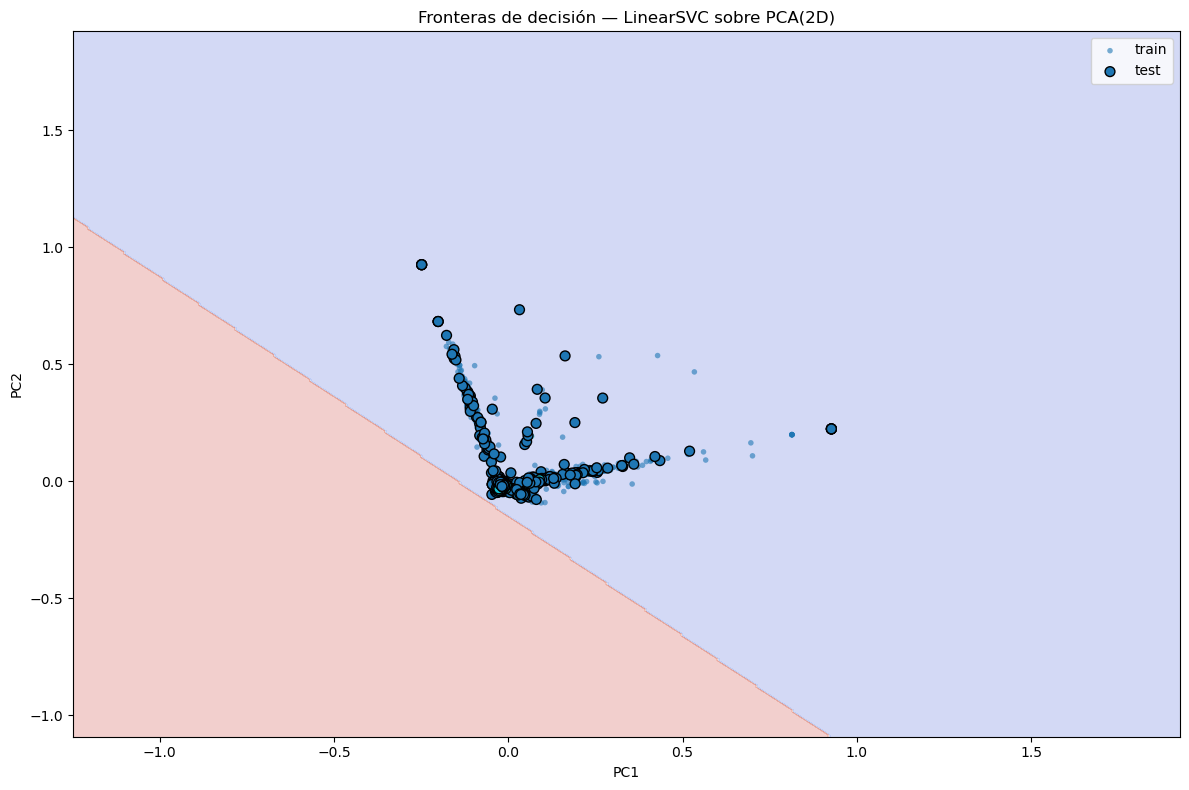

In [50]:
pca2 = PCA(n_components=2, random_state=42)
X_train_pca = pca2.fit_transform(X_train)
X_test_pca  = pca2.transform(X_test)

svc2_pca_model = LinearSVC(C=1.0, random_state=42)
svc2_pca_model.fit(X_train_pca, y_train)
y_pred = svc2_pca_model.predict(X_test_pca)

# malla en el plano PCA
x_min, x_max = X_train_pca[:,0].min()-1, X_train_pca[:,0].max()+1
y_min, y_max = X_train_pca[:,1].min()-1, X_train_pca[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
Z = svc2_pca_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, alpha=0.25, cmap="coolwarm")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap="tab10",
            s=16, edgecolor="none", alpha=0.6, label="train")
plt.scatter(X_test_pca[:,0],  X_test_pca[:,1],  c=y_test,  cmap="tab10",
            s=50, edgecolor="k",   label="test")
plt.title("Fronteras de decisión — LinearSVC sobre PCA(2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()